In [1]:
# !pip install -q keras-ocr
# !pip install ultralytics
# ! pip install paddlepaddle
# ! pip install paddleocr
# ! pip install deskew

# Importing the dependencies

In [ ]:
# Standard library imports
import re

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import torch
from PIL import Image
from IPython.display import display
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import rotate
from skimage.transform import resize

# Specialized libraries for OCR and NLP
from paddleocr import PaddleOCR, draw_ocr
from spacy.pipeline import EntityRuler
import spacy

# YOLO object detection
from ultralytics import YOLO

# Google Colab utility for displaying images
from google.colab.patches import cv2_imshow

# Deskewing
from deskew import determine_skew

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# Initialize OCR models
ocr = PaddleOCR(use_angle_cls=True, lang='en')

print("Everything Imported Successfully✅")

[2024/08/01 04:04:22] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

# Loading models and Test images

In [ ]:
# Loading all the trained YOLO models
card_model = YOLO("/content/drive/MyDrive/Samsung_Prism/cards_best.pt")
face_model = YOLO("/content/drive/MyDrive/Samsung_Prism/Face_best.pt")
qrbar_model = YOLO("/content/drive/MyDrive/Samsung_Prism/qrbar_best.pt")
with open("/content/drive/MyDrive/Samsung_Prism/names_set.pkl", 'rb') as file:
    names_set = pickle.load(file)

# test_1 = cv2.imread("/content/1_Card.jpeg")
# test_2 = cv2.imread("/content/2_Card_PGB.jpeg")
# test_3 = cv2.imread("/content/NP_BG.jpeg")
# test_4 = cv2.imread("/content/4_Cards.jpeg")
test_5 = cv2.imread("/content/5_Cards.jpeg")
print("Models and Image Loaded Succesfully✅")

Models and Image Loaded Succesfully✅


# Defining the utility functions

In [ ]:
def contains_personal_information(text, names_set):
    # Process the text with spaCy
    doc = nlp(text)

    # Check if any entities recognized as PERSON are found
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            return True

    # Additional check for specific names
    indian_last_names = [
        'Singh', 'Kumar', 'Sharma', 'Patel', 'Verma', 'Reddy', 'Jain', 'Gupta',
        'Mishra', 'Sinha', 'Chopra', 'Shukla', 'Mehta', 'Bhat', 'Desai', 'Yadav',
        'Rao', 'Nair', 'Naidu', 'Das', 'Sen', 'Dey', 'Roy', 'Banerjee','Mukherjee',
        'Chatterjee', 'Sengupta', 'Bhattacharya', 'Ghosh', 'Dasgupta', 'Pillai',
        'Panda', 'Mandal', 'Chakraborty', 'Kaur', 'Jha', 'Thakur', 'Saini', 'singh', 'SINGH'
    ]
    for name in indian_last_names:
        if re.search(r'\b' + re.escape(name) + r'\b', text, re.IGNORECASE):
            return True

    # Check if the word contains "SINGH", "singh", or "Singh" as part of it
    if re.search(r'\b\w*singh\w*\b', text, re.IGNORECASE):
        return True

    # Additional check for names in non-standard formats
    # Regex pattern to match names in the format 'LASTNAME, FIRSTNAME'
    name_pattern = r'\b[A-Z][A-Z]*, [A-Z][A-Z]*\b'
    if re.search(name_pattern, text):
        return True

    concatenated_name_pattern = r'\b(?:[A-Z][a-z]+){2,}\b'
    if re.search(concatenated_name_pattern, text):
        return True

    # Check if any name in the set is present in the text
    if names_set.intersection(text.split()):
        return True

    # Define a list of regex patterns for various date formats
    date_patterns = [
        r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b',         # Matches "dd/mm/yyyy", "mm-dd-yyyy"
        r'\b\d{4}[/-]\d{1,2}[/-]\d{1,2}\b',           # Matches "yyyy-mm-dd"
        r'\b\d{1,2}\s\w+\s\d{4}\b',                   # Matches "dd month yyyy"
        r'\b\w+\s\d{1,2},\s\d{4}\b',                  # Matches "Month dd, yyyy"
        r'\b\d{1,2}\.\d{1,2}\.\d{2,4}\b',             # Matches "dd.mm.yyyy"
        r'\b\d{4}\.\d{1,2}\.\d{1,2}\b',               # Matches "yyyy.mm.dd"
    ]

    # Define a regex pattern for numeric sequences
    numeric_pattern = r'\b\d{2,}\b'  # Matches sequences of digits of length 2 or more

    # Define a regex pattern for alphanumeric patterns like NZFPS8783D
    alphanumeric_pattern = r'\b[A-Z]{3,}[0-9]{2,}[A-Z]\b'

    # Check for date patterns
    for pattern in date_patterns:
        if re.search(pattern, text):
            return True

    # Check for numeric sequences
    if re.search(numeric_pattern, text):
        return True

    # Check for alphanumeric patterns
    if re.search(alphanumeric_pattern, text):
        return True

    return False

In [ ]:
def reverse_deskew(image, angle, original_shape):
    """
    Reverse the deskewing process by rotating the image back.
    """
    reversed_image = rotate(image, -angle, resize=True) * 255
    reversed_image = cv2.resize(reversed_image, (original_shape[1], original_shape[0]))
    return reversed_image.astype(np.uint8)

def map_back_to_original(original_image, reversed_area, box_coords):
    """
    Map the reversed deskewed area back to the original image.
    """
    x_min, y_min, x_max, y_max = box_coords
    original_image[y_min:y_max, x_min:x_max] = reversed_area
    return original_image


0: 640x480 5 Cardss, 730.6ms
Speed: 30.2ms preprocess, 730.6ms inference, 31.6ms postprocess per image at shape (1, 3, 640, 480)
[2024/08/01 04:18:43] ppocr DEBUG: dt_boxes num : 18, elapsed : 1.039477825164795
[2024/08/01 04:18:43] ppocr DEBUG: cls num  : 18, elapsed : 0.11890602111816406
[2024/08/01 04:18:49] ppocr DEBUG: rec_res num  : 18, elapsed : 6.430594444274902
Detected Text (0): 43, Confidence: 0.9764418601989746
Detected Text (0): -140001, Confidence: 0.962145984172821
Detected Text (0): S/O Gurpreet Singh#33,Piara Singh, Confidence: 0.9435084462165833
Detected Text (0): Colony.Ward Number 6,Rupnagar, Confidence: 0.9509150981903076
Detected Text (0): Punjab-140001, Confidence: 0.9934757947921753
Detected Text (0): 725818365814, Confidence: 0.9962863922119141
Detected Text (0): VID:9189191146237871, Confidence: 0.9688719511032104
Detected Text (0): 1947, Confidence: 0.976227879524231

0: 608x640 (no detections), 941.0ms
Speed: 6.6ms preprocess, 941.0ms inference, 0.8ms postp

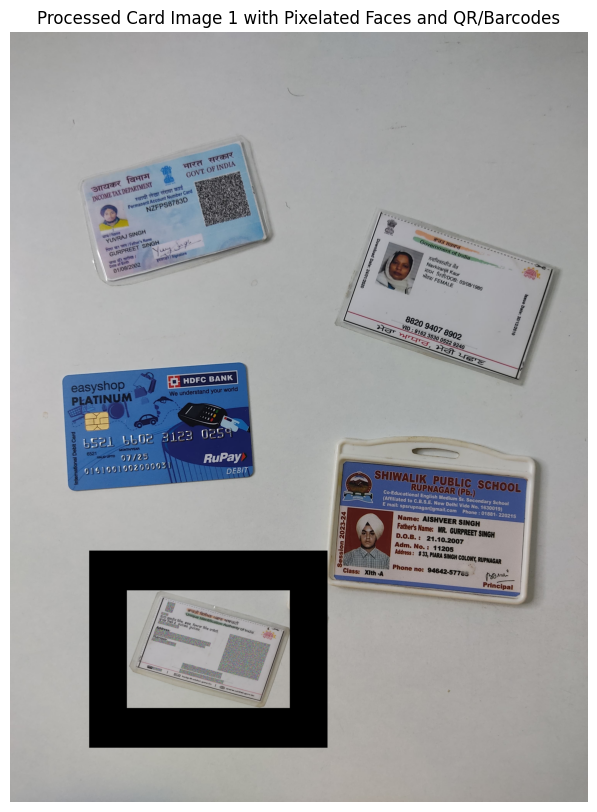

[2024/08/01 04:18:59] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3020329475402832
[2024/08/01 04:18:59] ppocr DEBUG: cls num  : 11, elapsed : 0.06201910972595215
[2024/08/01 04:19:00] ppocr DEBUG: rec_res num  : 11, elapsed : 1.153660535812378
Detected Text (1): Download Date:24/01/2020, Confidence: 0.9578303694725037
Detected Text (1): Navkiranjit Kaur, Confidence: 0.9708337187767029
Detected Text (1): Issue Date:30/12/2019, Confidence: 0.9525721669197083
Detected Text (1): 3/DB03/08/1980, Confidence: 0.9618719220161438
Detected Text (1): 882094078902, Confidence: 0.9801895022392273
Detected Text (1): VID:9162353005229240, Confidence: 0.970207691192627

0: 576x640 1 Face, 588.0ms
Speed: 7.8ms preprocess, 588.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 bar_code, 2 qr_codes, 580.2ms
Speed: 5.9ms preprocess, 580.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


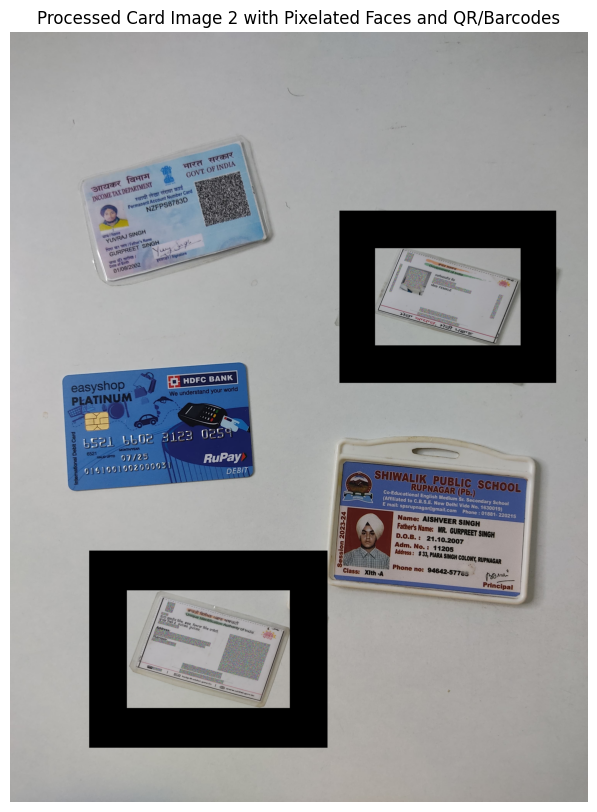

[2024/08/01 04:19:04] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.443408727645874
[2024/08/01 04:19:04] ppocr DEBUG: cls num  : 16, elapsed : 0.08054661750793457
[2024/08/01 04:19:05] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1567003726959229
Detected Text (2): NZFPS8783D, Confidence: 0.9908480644226074
Detected Text (2): 14/Name, Confidence: 0.8831874132156372
Detected Text (2): YUVRAJ SINGH, Confidence: 0.9546892046928406
Detected Text (2): GURPREET SINGH, Confidence: 0.9599454998970032
Detected Text (2): 01/08/2002, Confidence: 0.9975358247756958

0: 576x640 1 Face, 819.7ms
Speed: 5.7ms preprocess, 819.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 2 qr_codes, 828.0ms
Speed: 5.3ms preprocess, 828.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


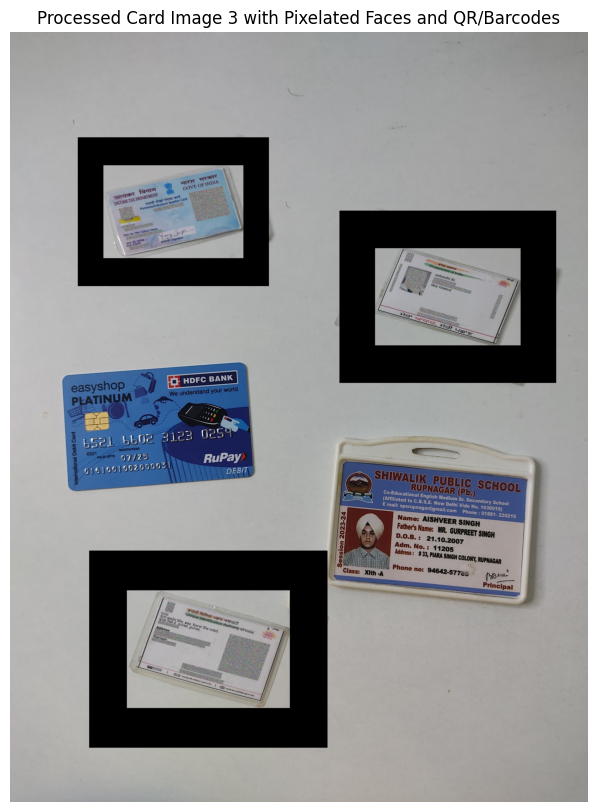

[2024/08/01 04:19:12] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.6167318820953369
[2024/08/01 04:19:12] ppocr DEBUG: cls num  : 15, elapsed : 0.13692688941955566
[2024/08/01 04:19:13] ppocr DEBUG: rec_res num  : 15, elapsed : 1.160677433013916
Detected Text (3): 6521, Confidence: 0.9816728830337524
Detected Text (3): 66023123, Confidence: 0.9626641869544983
Detected Text (3): 0259, Confidence: 0.9713020324707031
Detected Text (3): 6521, Confidence: 0.9987273216247559
Detected Text (3): 07/25, Confidence: 0.9934713244438171
Detected Text (3): RuPay, Confidence: 0.9971023797988892
Detected Text (3): 0161001002000031, Confidence: 0.985600471496582

0: 448x640 (no detections), 497.8ms
Speed: 5.7ms preprocess, 497.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 bar_codes, 1 qr_code, 474.0ms
Speed: 4.4ms preprocess, 474.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


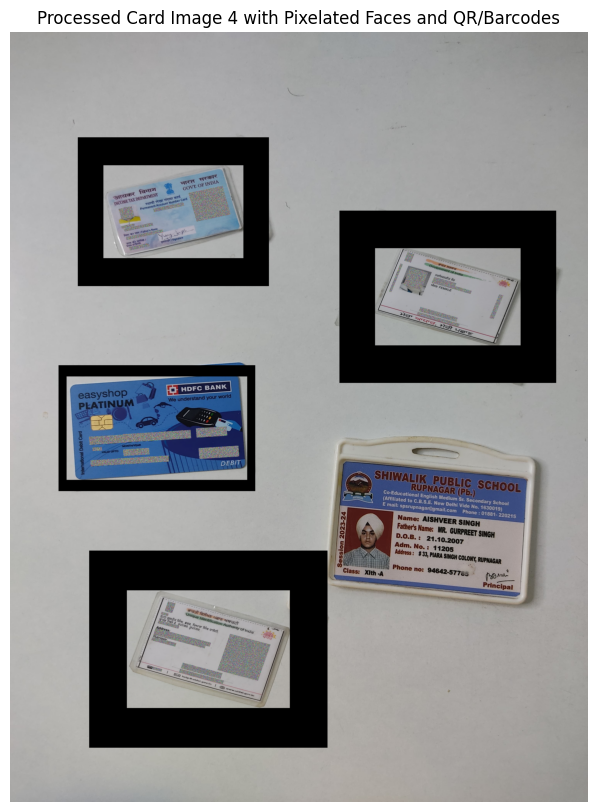

[2024/08/01 04:19:17] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.43793416023254395
[2024/08/01 04:19:17] ppocr DEBUG: cls num  : 15, elapsed : 0.06227231025695801
[2024/08/01 04:19:19] ppocr DEBUG: rec_res num  : 15, elapsed : 2.1690356731414795
Detected Text (4): (Affiliated to C.B.S.E.NewDelhi Vide No.1630019, Confidence: 0.9397113919258118
Detected Text (4): E mail:spsrupnagar@gmail.comPhone:01881-220215, Confidence: 0.960223913192749
Detected Text (4): Name: AISHVEER SINGH, Confidence: 0.9382823705673218
Detected Text (4): Session 2023-24, Confidence: 0.9662247896194458
Detected Text (4): Father's Name: MR. GURPREET SINGH, Confidence: 0.924735963344574
Detected Text (4): D.0.B.21.10.2007, Confidence: 0.9680212736129761
Detected Text (4): Adm.No.11205, Confidence: 0.9767609238624573
Detected Text (4): Address:#33,PIARA SINGH COLONY,RUPNAGAR, Confidence: 0.9052449464797974
Detected Text (4): Phone no: 94642-57785, Confidence: 0.9280844926834106

0: 544x640 2 Faces, 537.2ms
Speed: 5.

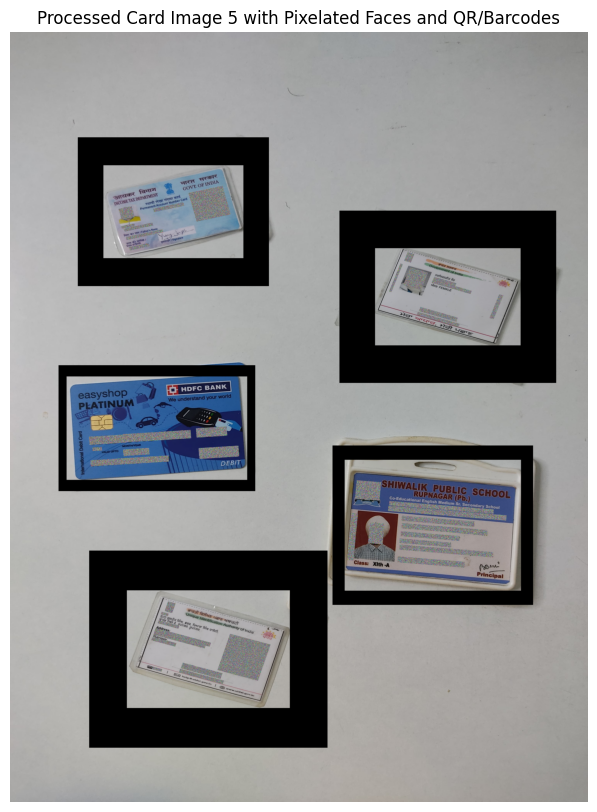

In [ ]:
def process_cards(image, card_model, face_model, qrbar_model, determine_skew, rotate, ocr, contains_personal_information, names_set):
    """
    Process cards in the given image by detecting, deskewing, and pixelating faces and QR/barcodes.

    Parameters:
    - image: The input image containing the cards.
    - card_model: The model used to detect cards in the image.
    - face_model: The model used to detect faces in the card images.
    - qrbar_model: The model used to detect QR/barcode in the card images.
    - determine_skew: Function to determine the skew angle of an image.
    - rotate: Function to rotate an image by a given angle.
    - ocr: OCR model or function.
    - contains_personal_information: Function to check if text contains personal information.
    - names_set: Set of personal names to detect.

    Returns:
    - processed_image: The image with pixelated faces and QR/barcodes in the cards.
    """
    # Make a copy of the input image to avoid modifying the original
    image_copy = image.copy()

    # Use the card model to detect cards in the image
    card_results = card_model(image_copy)

    # Iterate over each bounding box detected by the card model
    for i, card_box in enumerate(card_results[0].boxes.data):

        # Extract coordinates of the bounding box and convert to integers
        card_x_min, card_y_min, card_x_max, card_y_max = map(int, card_box[:4])

        # Crop the image to the bounding box area to isolate the card
        card_area = image_copy[card_y_min:card_y_max, card_x_min:card_x_max]
        original_shape = card_area.shape

        # Convert the card area to grayscale for skew detection
        grayscale_card_area = cv2.cvtColor(card_area, cv2.COLOR_BGR2GRAY)

        # Determine the skew angle of the card image
        angle = determine_skew(grayscale_card_area)

        # Deskew the card area by rotating it by the determined angle
        deskewed_card_area = rotate(card_area, angle, resize=True) * 255
        deskewed_card_area = np.uint8(deskewed_card_area)

        # Perform OCR on the deskewed image
        gray_img = cv2.cvtColor(deskewed_card_area, cv2.COLOR_BGR2GRAY)
        result = ocr.ocr(gray_img, cls=True)

        # Print detected texts that contain personal information
        detection_indexes = set()
        for index, res in enumerate(result[0]):
            box_text = res[1][0]
            confidence = res[1][1]
            if contains_personal_information(box_text, names_set):
                print(f"Detected Text ({i}): {box_text}, Confidence: {confidence}")
                detection_indexes.add(index)

        # Mask detected personal information areas
        for det in detection_indexes:
            coordinates = result[0][det][0]
            x_min = int(min(coord[0] for coord in coordinates))
            y_min = int(min(coord[1] for coord in coordinates))
            x_max = int(max(coord[0] for coord in coordinates))
            y_max = int(max(coord[1] for coord in coordinates))

            # Extract the image patch
            patch = deskewed_card_area[y_min:y_max, x_min:x_max]

            # Pixelate the extracted patch
            pixel_size = 5
            pixelated_area = cv2.resize(patch, (0, 0), fx=1/pixel_size, fy=1/pixel_size, interpolation=cv2.INTER_NEAREST)
            pixelated_area = cv2.resize(pixelated_area, (patch.shape[1], patch.shape[0]), interpolation=cv2.INTER_NEAREST)
            pixelated_area = np.random.randint(0, 256, size=pixelated_area.shape, dtype=np.uint8)  # Random colors

            # Overlay the pixelated area back onto the card
            overlay_y_min = max(0, y_min)
            overlay_y_max = min(deskewed_card_area.shape[0], y_max)
            overlay_x_min = max(0, x_min)
            overlay_x_max = min(deskewed_card_area.shape[1], x_max)
            deskewed_card_area[overlay_y_min:overlay_y_max, overlay_x_min:overlay_x_max] = pixelated_area[:overlay_y_max-overlay_y_min, :overlay_x_max-overlay_x_min]

        # Detect faces from the card area
        face_results = face_model(deskewed_card_area)

        # Iterate over each face bounding box detected
        for face_box in face_results[0].boxes.data:
            face_x_min, face_y_min, face_x_max, face_y_max = map(int, face_box[:4])

            # Crop the face area from the card
            face_area = deskewed_card_area[face_y_min:face_y_max, face_x_min:face_x_max]

            # Mask the face area by pixelating it
            pixel_size = 5
            pixelated_area = cv2.resize(face_area, (0, 0), fx=1/pixel_size, fy=1/pixel_size, interpolation=cv2.INTER_NEAREST)
            pixelated_area = cv2.resize(pixelated_area, (face_x_max - face_x_min, face_y_max - face_y_min), interpolation=cv2.INTER_NEAREST)
            pixelated_area = np.random.randint(0, 256, size=pixelated_area.shape, dtype=np.uint8)  # Random colors

            # Overlay the pixelated area back onto the card
            deskewed_card_area[face_y_min:face_y_max, face_x_min:face_x_max] = pixelated_area

        # Detect QR/barcodes from the card area
        qrbar_results = qrbar_model(deskewed_card_area)

        # Iterate over each QR/barcode bounding box detected
        for qrbar_box in qrbar_results[0].boxes.data:
            qrbar_x_min, qrbar_y_min, qrbar_x_max, qrbar_y_max = map(int, qrbar_box[:4])

            # Crop the QR/barcode area from the card
            qrbar_area = deskewed_card_area[qrbar_y_min:qrbar_y_max, qrbar_x_min:qrbar_x_max]

            # Mask the QR/barcode area by pixelating it
            pixel_size = 5
            pixelated_area = cv2.resize(qrbar_area, (0, 0), fx=1/pixel_size, fy=1/pixel_size, interpolation=cv2.INTER_NEAREST)
            pixelated_area = cv2.resize(pixelated_area, (qrbar_x_max - qrbar_x_min, qrbar_y_max - qrbar_y_min), interpolation=cv2.INTER_NEAREST)
            pixelated_area = np.random.randint(0, 256, size=pixelated_area.shape, dtype=np.uint8)  # Random colors

            # Overlay the pixelated area back onto the card
            deskewed_card_area[qrbar_y_min:qrbar_y_max, qrbar_x_min:qrbar_x_max] = pixelated_area

        # Reverse the deskewing process
        original_card_area = reverse_deskew(deskewed_card_area, angle, original_shape)
        original_card_area_cropped = original_card_area[:original_shape[0], :original_shape[1]]
        mapped_image = map_back_to_original(image_copy, original_card_area_cropped, (card_x_min, card_y_min, card_x_max, card_y_max))

        # Plot the results for the current card
        plt.figure(figsize=(10, 10))
        mapped_image_rgb = cv2.cvtColor(mapped_image, cv2.COLOR_BGR2RGB)
        plt.imshow(mapped_image_rgb)
        plt.axis("off")
        plt.title(f"Processed Card Image {i + 1} with Pixelated Faces and QR/Barcodes")
        plt.show()

# Calling the function
processed_image = process_cards(test_5, card_model, face_model, qrbar_model, determine_skew, rotate, ocr, contains_personal_information, names_set)

# Demonstration of the OCR


0: 640x480 1 Cards, 1289.8ms
Speed: 8.1ms preprocess, 1289.8ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 480)
[2024/07/27 07:44:48] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3298773765563965
[2024/07/27 07:44:48] ppocr DEBUG: cls num  : 14, elapsed : 0.11719655990600586
[2024/07/27 07:44:51] ppocr DEBUG: rec_res num  : 14, elapsed : 2.1404993534088135
Detected Text: 3 Aflated.to C..S.E.New De Vite No.1630019) 0.7822081446647644
Detected Text: 4 ession 2023-24 0.9600928425788879
Detected Text: 5 Name: AISHVEER SINGH 0.9210193753242493
Detected Text: 6 Father's Name: MR. GURPREET SINGH 0.9170876145362854
Detected Text: 7 D.0.B.21.10.2007 0.9710182547569275
Detected Text: 8 Adm.No.11205 0.9852617383003235
Detected Text: 9 Address#33PIARA SINGH COLONY, RUPNAGAR 0.9075882434844971
Detected Text: 10 Phone no:94642-57765 0.9361950159072876


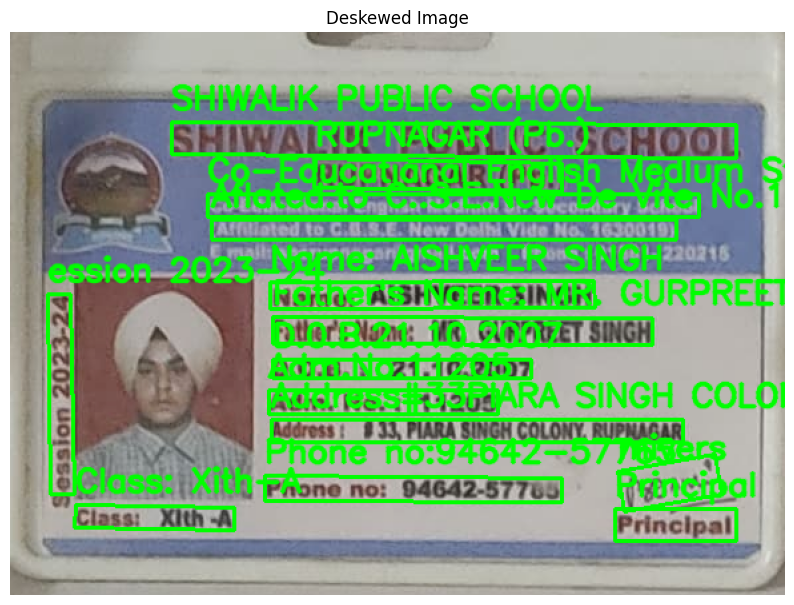

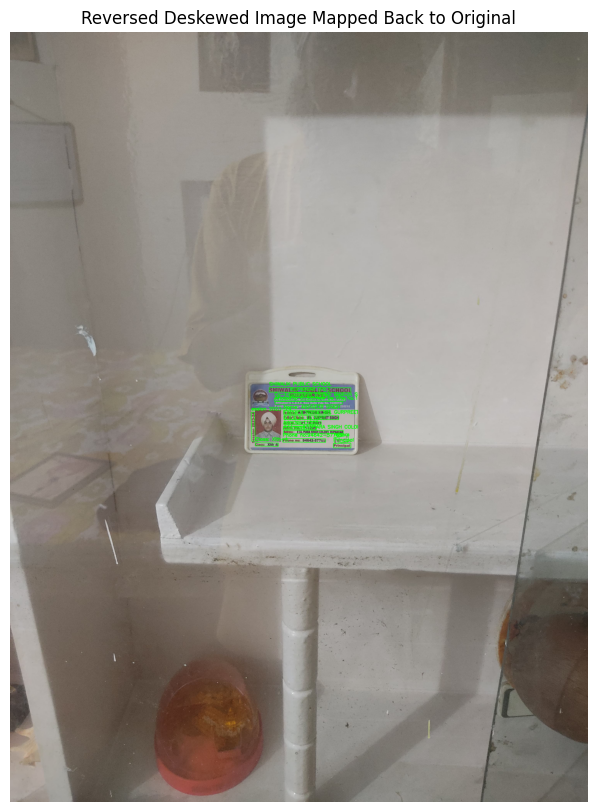

In [ ]:
# Copy the input image for processing (Make sure you have loaded the image first)
image_copy = test_1.copy()

# Use the card model to detect cards in the image
card_results = card_model(image_copy)

# Iterate over each bounding box detected by the card model
for card_box in card_results[0].boxes.data:

    # Extract coordinates of the bounding box and convert to integers
    card_x_min, card_y_min, card_x_max, card_y_max = map(int, card_box[:4])

    # Crop the image to the bounding box area to isolate the card
    card_area = image_copy[card_y_min:card_y_max, card_x_min:card_x_max]
    original_shape = card_area.shape

    # Convert the card area to grayscale for skew detection
    grayscale_card_area = cv2.cvtColor(card_area, cv2.COLOR_BGR2GRAY)

    # Determine the skew angle of the card image
    angle = determine_skew(grayscale_card_area)

    # Deskew the card area by rotating it by the determined angle
    deskewed_card_area = rotate(card_area, angle, resize=True) * 255

    # Convert to uint8 if necessary
    if deskewed_card_area.dtype != np.uint8:
        deskewed_card_area = np.uint8(deskewed_card_area)

    # Perform OCR on the deskewed image
    gray_img = cv2.cvtColor(deskewed_card_area, cv2.COLOR_BGR2GRAY)
    result = ocr.ocr(gray_img, cls=True)

    # Print detected texts that contain personal information
    for index, res in enumerate(result[0]):
        box_text = res[1][0]
        confidence = res[1][1]
        if contains_personal_information(box_text, names_set):
            print("Detected Text:", index, box_text, confidence)

    # Prepare to display the deskewed image
    boxes = [res[0] for res in result[0]]
    txts = [res[1][0] for res in result[0]]
    scores = [res[1][1] for res in result[0]]

    # Plotting the results for the deskewed image
    plt.figure(figsize=(10, 10))
    plt.imshow(deskewed_card_area)

    for box, text, score in zip(boxes, txts, scores):
        box = np.array(box).astype(int)
        cv2.polylines(deskewed_card_area, [box], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.putText(deskewed_card_area, text, (box[0][0], box[0][1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

    # Convert to RGB for displaying in matplotlib
    deskewed_card_area_rgb = cv2.cvtColor(deskewed_card_area, cv2.COLOR_BGR2RGB)
    plt.imshow(deskewed_card_area_rgb)
    plt.axis("off")
    plt.title("Deskewed Image")
    plt.show()

    # Reverse the deskewing process
    original_card_area = reverse_deskew(deskewed_card_area, angle, original_shape)

    # Remove black borders by cropping to the original bounding box size
    h, w = original_shape[:2]
    original_card_area_cropped = original_card_area[:h, :w]

    # Map the reversed deskewed area back to the original image
    mapped_image = map_back_to_original(image_copy, original_card_area_cropped, (card_x_min, card_y_min, card_x_max, card_y_max))

    # Plotting the results for the reversed deskewed image mapped back to the original image
    plt.figure(figsize=(10, 10))
    mapped_image_rgb = cv2.cvtColor(mapped_image, cv2.COLOR_BGR2RGB)
    plt.imshow(mapped_image_rgb)
    plt.axis("off")
    plt.title("Reversed Deskewed Image Mapped Back to Original")
    plt.show()


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textdet/dbnet/dbnet_resnet18_fpnc_1200e_icdar2015/dbnet_resnet18_fpnc_1200e_icdar2015_20220825_221614-7c0e94f2.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

07/25 10:29:31 - mmengine - WARNING - Failed to search registry with scope "mmocr" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmocr" is a correct scope, or whether the registry is initialized.
07/25 10:29:31 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


Output()

Model loaded!


Loading text recognition model...
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/satrn/satrn_shallow-small_5e_st_mj/satrn_shallow-small_5e_st_mj_20220915_152442-5591bf27.pth


Downloading: "https://download.openmmlab.com/mmocr/textrecog/satrn/satrn_shallow-small_5e_st_mj/satrn_shallow-small_5e_st_mj_20220915_152442-5591bf27.pth" to /root/Ikomia/Plugins/Python/infer_mmlab_text_recognition/models/checkpoints/satrn_shallow-small_5e_st_mj_20220915_152442-5591bf27.pth


Output()

The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

Model loaded!


Output()

Workflow Untitled run successfully in 116736.857588 ms.


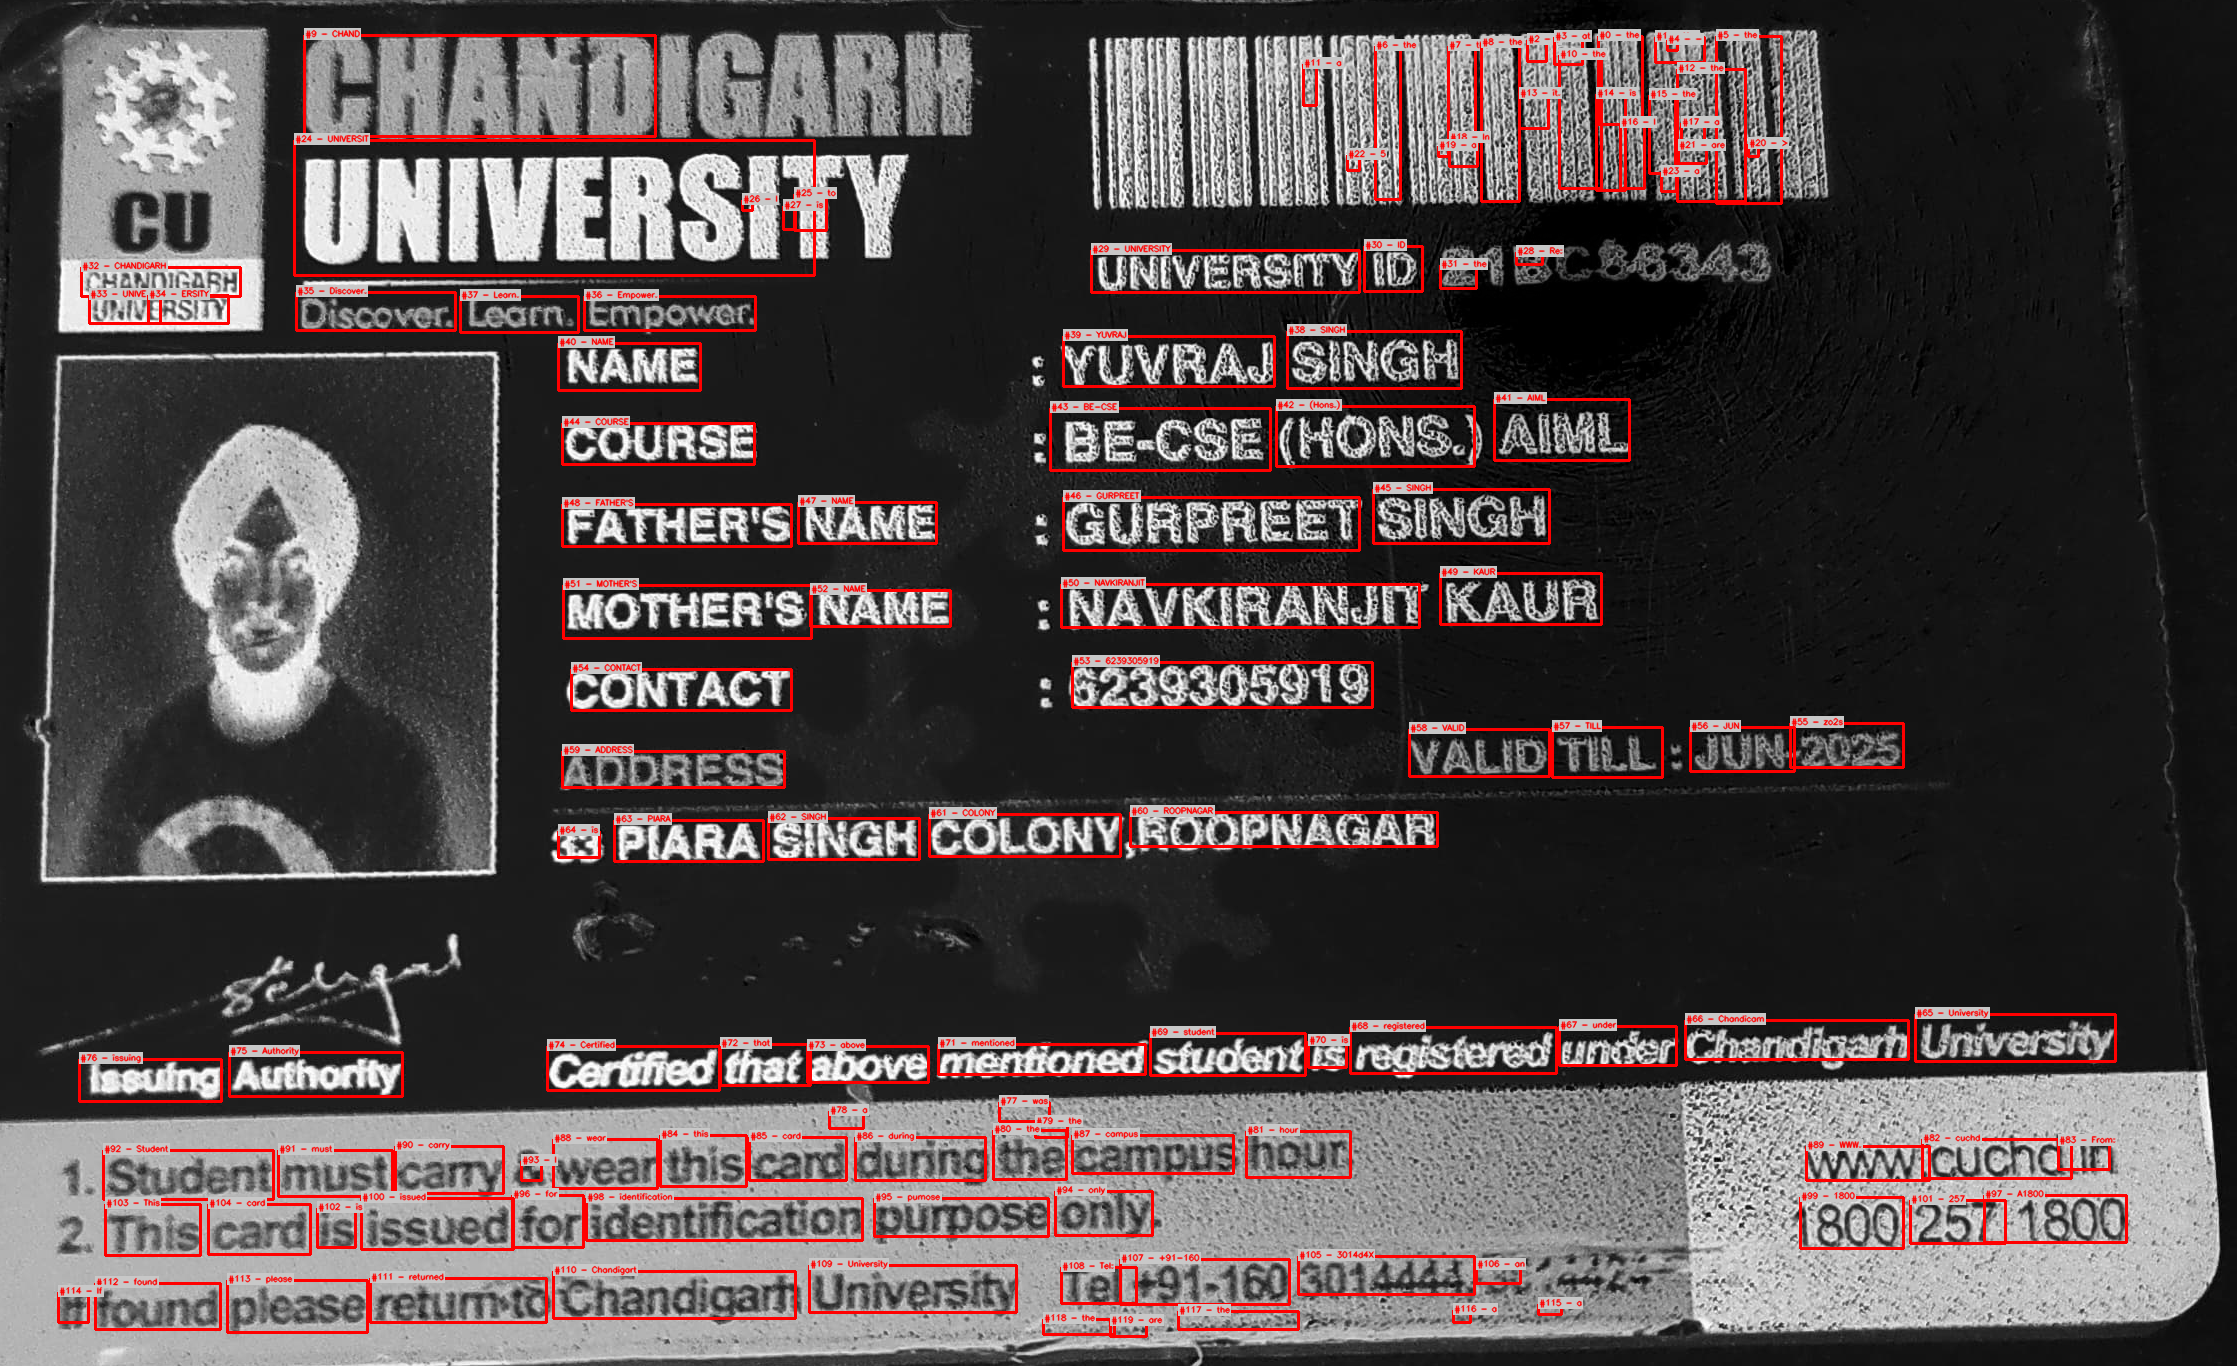